## 1 Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
def process_dating_csv(input_file, output_file: str):
    # Read the dataset and select the first 6500 rows
    df = pd.read_csv(input_file).head(6500)
    df = df.drop(['race', 'race_o', 'field'], axis=1)
    ######################################################################
    # Function to label encode specified columns
    def label_encode_columns(df, columns):
        label_encodings = {} # Creat a new dictionary
        for col in columns:
            unique_values = sorted(df[col].unique())  # Sort alphabetically/lexicographically
            label_encodings[col] = {val: idx for idx, val in enumerate(unique_values)} # label_encodings[col] means creat a key[col] in the dictionary
                                                                                       # This constructs a dictionary by looping through (for loop)
            df[col] = df[col].map(label_encodings[col])
        
        # Output specific mappings
        print(f"Value assigned for male in column gender: {label_encodings['gender'].get('male', 'Not found')}.")
    
    # Apply label encoding
    label_encode_columns(df, ['gender'])
    ######################################################################
    # Function to normalize scores for specified columns
    def normalize_scores(df, columns, total_column):
        df[total_column] = df[columns].sum(axis=1) # axis =1 means "across columns",For example, if columns = ['math', 'science', 'english'], 
                                                   # this will calculate the sum of these three scores for each row.
        for col in columns:
            df[col] = df[col] / df[total_column]
    
    # Normalize the participant and partner scores
    participant_columns = ['attractive_important', 'sincere_important', 'intelligence_important', 
                           'funny_important', 'ambition_important', 'shared_interests_important']
    partner_columns = ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 
                       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']
    
    normalize_scores(df, participant_columns, 'participant_total')
    normalize_scores(df, partner_columns, 'partner_total')
    ######################################################################
    # Function to calculate and print the mean for specified columns
    def calculate_means(df, columns):
        for col in columns:
            mean_value = round(df[col].mean(), 2)    #df[col].mean(): This calculates the mean (average) of the values in the column col.
                                                     #round(..., 2): The result is rounded to 2 decimal
            print(f"Mean of {col}: {mean_value}")
    
    # Calculate and print means
    calculate_means(df, participant_columns)
    calculate_means(df, partner_columns)
    ######################################################################
    # Save the cleaned data to a new CSV file
    df.drop(['participant_total', 'partner_total'], axis=1).to_csv(output_file, index=False)
    ######################################################################
# call process_dating_csv function 
process_dating_csv('dating-full.csv', 'dating.csv')

Value assigned for male in column gender: 1.
Mean of attractive_important: 0.22
Mean of sincere_important: 0.18
Mean of intelligence_important: 0.2
Mean of funny_important: 0.17
Mean of ambition_important: 0.11
Mean of shared_interests_important: 0.12
Mean of pref_o_attractive: 0.22
Mean of pref_o_sincere: 0.17
Mean of pref_o_intelligence: 0.2
Mean of pref_o_funny: 0.17
Mean of pref_o_ambitious: 0.11
Mean of pref_o_shared_interests: 0.12


In [3]:
# Load the dataset
df = pd.read_csv('dating.csv')

# Discretize all continuous-valued columns using 2 bins with labels [0, 1]
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column] = pd.cut(df[column], bins=2, labels=[0, 1])

# Save the processed dataset to a new file
output_file = 'dating_categorical.csv'
df.to_csv(output_file, index=False)


In [4]:
def split_train_test(input_file: str, train_file: str, test_file: str):
    # Read the dataset from the CSV file
    df = pd.read_csv(input_file)
    
    # Randomly sample 20% of the data for the test set using random_state=47
    test_set = df.sample(frac=0.2, random_state=47)
    
    # The remaining 80% will be used as the training set
    train_set = df.drop(test_set.index)
    
    # Save the test set to a CSV file
    test_set.to_csv(test_file, index=False)
    
    # Save the training set to a CSV file
    train_set.to_csv(train_file, index=False)

# Call the function with input and output file names
split_train_test('dating_categorical.csv', 'trainingSet.csv', 'testSet.csv')

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## 2 Implement Decision Trees, Bagging and Random Forests

### 2.1 Decision Trees

In [5]:
# Helper functions for Gini impurity and Gini gain
def gini_impurity(y):
    # Get unique classes and their respective counts in y
    classes, counts = np.unique(y, return_counts=True)
    
    # Initialize impurity to 1.0 (before subtracting class probabilities squared)
    impurity = 1.0
    
    # Calculate the Gini impurity by summing the squared probabilities of each class
    for count in counts:
        probability = count / len(y)  # Proportion of elements in this class
        impurity -= probability ** 2  # Subtract squared probability from impurity
    
    return impurity

def gini_gain(y, y_left, y_right):
    n = len(y)
    n_left, n_right = len(y_left), len(y_right)
    weighted_avg = (n_left / n) * gini_impurity(y_left) + (n_right / n) * gini_impurity(y_right)
    return gini_impurity(y) - weighted_avg
#####################################################
# Node for the decision tree
class DecisionTreeNode:
    def __init__(self, depth=0, max_depth=8, min_samples=50):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.is_leaf = False
        self.prediction = None

    def fit(self, X, y):
        if self.depth >= self.max_depth or len(y) < self.min_samples or len(np.unique(y)) == 1:
            self.is_leaf = True
            # Convert y to integers to use np.bincount for the majority class
            self.prediction = np.bincount(y.astype(int)).argmax()
            return

        best_gain = 0
        best_split = None
        best_left_y, best_right_y = None, None

        # Try all features and possible thresholds to find the best split
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                y_left, y_right = y[left_indices], y[right_indices]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = gini_gain(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_index, threshold)
                    best_left_y, best_right_y = y_left, y_right

        # If no gain, make this a leaf
        if best_gain == 0:
            self.is_leaf = True
            self.prediction = np.bincount(y).argmax()
            return

        # Split and create child nodes
        self.feature_index, self.threshold = best_split
        left_indices = X[:, self.feature_index] <= self.threshold
        right_indices = X[:, self.feature_index] > self.threshold
        self.left = DecisionTreeNode(depth=self.depth + 1, max_depth=self.max_depth, min_samples=self.min_samples)
        self.right = DecisionTreeNode(depth=self.depth + 1, max_depth=self.max_depth, min_samples=self.min_samples)
        self.left.fit(X[left_indices], y[left_indices])
        self.right.fit(X[right_indices], y[right_indices])

    def predict_one(self, x):
        if self.is_leaf:
            return self.prediction
        if x[self.feature_index] <= self.threshold:
            return self.left.predict_one(x)
        else:
            return self.right.predict_one(x)
    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])
        
# Decision Tree Classifier
class DecisionTreeStructure:
    def __init__(self, max_depth=8, min_samples=50):
        self.root = DecisionTreeNode(max_depth=max_depth, min_samples=min_samples)

    def fit(self, X, y):
        self.root.fit(X, y)

    def predict(self, X):
        return np.array([self.root.predict_one(x) for x in X])

# Main function for loading data, training, and testing
def decisionTree(trainingDataFilename, testDataFilename):
    # Load datasets
    train_df = pd.read_csv(trainingDataFilename)
    test_df = pd.read_csv(testDataFilename)

    # Separate features and labels
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    # Initialize and train the decision tree
    model = DecisionTreeStructure(max_depth=8, min_samples=50)
    model.fit(X_train, y_train)

    # Predict and calculate accuracy on the training set
    train_predictions = model.predict(X_train)
    train_accuracy = np.mean(train_predictions == y_train)

    # Predict and calculate accuracy on the testing set
    test_predictions = model.predict(X_test)
    test_accuracy = np.mean(test_predictions == y_test)

    # Print results
    print(f"Training Accuracy DT: {train_accuracy:.2f}")
    print(f"Testing Accuracy DT: {test_accuracy:.2f}")

decisionTree('trainingSet.csv', 'testSet.csv')


Training Accuracy DT: 0.78
Testing Accuracy DT: 0.70


### 2.2 Bagging

In [6]:
# DecisionTree and DecisionTreeNode from 2.1 DecisionTree implementation
class BaggedDecisionTree:
    def __init__(self, n_trees=30, max_depth=8, min_samples=50):
        self.n_trees = n_trees
        self.trees = [
            DecisionTreeStructure(max_depth=max_depth, min_samples=min_samples) for _ in range(n_trees)
        ]

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        for tree in self.trees:
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)

    def predict(self, X):
        # Collect predictions from each tree
        predictions = np.array([tree.predict(X) for tree in self.trees])
        # Majority voting for each sample (axis=0 for column-wise majority)
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return majority_vote

# Function to evaluate the bagging classifier
def bagging(trainingSet, testSet):
    # Load training and test datasets
    train_df = pd.read_csv(trainingSet)
    test_df = pd.read_csv(testSet)

    # Separate features and labels
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    # Initialize and train the bagged decision tree model
    model = BaggedDecisionTree(n_trees=30, max_depth=8, min_samples=50)
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy on training data
    train_predictions = model.predict(X_train)
    train_accuracy = np.mean(train_predictions == y_train)

    # Make predictions and calculate accuracy on test data
    test_predictions = model.predict(X_test)
    test_accuracy = np.mean(test_predictions == y_test)

    # Print results
    print(f"Training Accuracy BT: {train_accuracy:.2f}")
    print(f"Testing Accuracy BT: {test_accuracy:.2f}")

bagging('trainingSet.csv', 'testSet.csv')


Training Accuracy BT: 0.81
Testing Accuracy BT: 0.75


### 2.3 Random Forests

In [7]:
# DecisionTree and DecisionTreeNode from 2.1 DecisionTree implementation
class RandomForestDecisionTree(DecisionTreeStructure):
    def __init__(self, max_depth=8, min_samples=50, max_features=None):
        super().__init__(max_depth=max_depth, min_samples=min_samples)
        self.max_features = max_features  # Number of features to select at each split

    def fit(self, X, y):
        # Randomly select a subset of features for this tree
        self.features = np.random.choice(X.shape[1], self.max_features, replace=False)
        X_subset = X[:, self.features]  # Only use selected features
        super().fit(X_subset, y)

    def predict_one(self, x):
        # Use only selected features for prediction
        x_subset = x[self.features]
        return super().predict_one(x_subset)

class RandomForest:
    def __init__(self, n_trees=30, max_depth=8, min_samples=50, max_features=None):
        self.n_trees = n_trees
        self.trees = []

        # Prepare each tree with the specified number of features
        for _ in range(n_trees):
            self.trees.append(RandomForestDecisionTree(max_depth=max_depth, min_samples=min_samples, max_features=max_features))

    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        for tree in self.trees:
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return majority_vote

# Function to evaluate the random forest classifier
def randomForests(trainingSet, testSet):
    # Load training and test datasets
    train_df = pd.read_csv(trainingSet)
    test_df = pd.read_csv(testSet)

    # Separate features and labels
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    # Get total number of features (p)
    p = X_train.shape[1]
    max_features = int(math.sqrt(p))  # Calculate √p

    # Initialize and train the random forest model
    model = RandomForest(n_trees=30, max_depth=8, min_samples=50, max_features=max_features)
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy on training data
    train_predictions = model.predict(X_train)
    train_accuracy = np.mean(train_predictions == y_train)

    # Make predictions and calculate accuracy on test data
    test_predictions = model.predict(X_test)
    test_accuracy = np.mean(test_predictions == y_test)

    # Print results
    print(f"Training Accuracy RF: {train_accuracy:.2f}")
    print(f"Testing Accuracy RF: {test_accuracy:.2f}")

randomForests('trainingSet.csv', 'testSet.csv')


Training Accuracy RF: 0.56
Testing Accuracy RF: 0.58


In [11]:
import numpy as np
import pandas as pd
import math

# Node structure for decision tree
class Node:
    def __init__(self, is_leaf=False, prediction=None, feature=None, threshold=None, left=None, right=None):
        self.is_leaf = is_leaf  # Indicates whether this is a leaf node
        self.prediction = prediction  # Prediction for leaf nodes
        self.feature = feature  # Feature used for splitting
        self.threshold = threshold  # Threshold for splitting
        self.left = left  # Left child node
        self.right = right  # Right child node

class RandomForestDecisionTree:
    def __init__(self, max_depth=8, min_samples=50, max_features=None):
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples = min_samples  # Minimum samples required to split a node
        self.max_features = max_features  # Number of features to randomly select at each split
        self.tree = None  # Root node of the tree

    def gini_index(self, left_labels, right_labels):
        # Calculate the Gini impurity for a split
        def gini(labels):
            proportions = np.bincount(labels) / len(labels)
            return 1.0 - np.sum(proportions**2)
        
        left_size, right_size = len(left_labels), len(right_labels)
        total_size = left_size + right_size
        return (left_size / total_size) * gini(left_labels) + (right_size / total_size) * gini(right_labels)

    def best_split(self, X, y, feature_idxs):
        # Find the best feature and threshold to split the data
        best_feature, best_threshold = None, None
        best_gini = float('inf')  # Initialize with a high Gini value
        
        # Iterate through the selected features
        for feature in feature_idxs:
            thresholds = np.unique(X[:, feature])  # All unique values of the feature
            for threshold in thresholds:
                # Split data into left and right groups
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                # Skip if either group has no samples
                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue

                # Calculate Gini impurity for the split
                gini = self.gini_index(y[left_mask], y[right_mask])
                if gini < best_gini:
                    best_gini = gini
                    best_feature, best_threshold = feature, threshold

        return best_feature, best_threshold

    def create_leaf(self, y):
        # Create a leaf node with the majority class label
        prediction = np.bincount(y).argmax()
        return Node(is_leaf=True, prediction=prediction)

    def create_internal_node(self, feature, threshold, left, right):
        # Create an internal node with a splitting condition
        return Node(is_leaf=False, feature=feature, threshold=threshold, left=left, right=right)

    def fit_node(self, X, y, depth):
        # Randomly select features for this node
        feature_idxs = np.random.choice(X.shape[1], self.max_features, replace=False)
        # Find the best split based on the selected features
        best_feature, best_threshold = self.best_split(X, y, feature_idxs)

        # Stopping conditions: no split found, max depth reached, or too few samples
        if best_feature is None or depth >= self.max_depth or len(y) < self.min_samples:
            return self.create_leaf(y)  # Create a leaf node

        # Split the data based on the best feature and threshold
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        # Recursively build the left and right subtrees
        left_child = self.fit_node(X[left_mask], y[left_mask], depth + 1)
        right_child = self.fit_node(X[right_mask], y[right_mask], depth + 1)

        # Create and return an internal node
        return self.create_internal_node(best_feature, best_threshold, left_child, right_child)

    def fit(self, X, y):
        # Fit the tree starting from the root
        self.tree = self.fit_node(X, y, depth=0)

    def predict_one(self, x):
        # Predict the label for a single sample
        node = self.tree
        while not node.is_leaf:
            # Traverse the tree based on the feature threshold
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.prediction

    def predict(self, X):
        # Predict labels for a batch of samples
        return np.array([self.predict_one(x) for x in X])


class RandomForest:
    def __init__(self, n_trees=30, max_depth=8, min_samples=50, max_features=None):
        self.n_trees = n_trees  # Number of trees in the forest
        self.trees = []

        # Initialize each tree with the specified number of features
        for _ in range(n_trees):
            self.trees.append(RandomForestDecisionTree(max_depth=max_depth, min_samples=min_samples, max_features=max_features))

    def bootstrap_sample(self, X, y):
        # Create a bootstrap sample of the data
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        # Train each tree using a bootstrap sample of the data
        for tree in self.trees:
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)

    def predict(self, X):
        # Aggregate predictions from all trees using majority voting
        predictions = np.array([tree.predict(X) for tree in self.trees])
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return majority_vote


# Random forest evaluation
def randomForests(trainingSet, testSet):
    # Load training and test datasets
    train_df = pd.read_csv(trainingSet)
    test_df = pd.read_csv(testSet)

    # Separate features and labels
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    # Get total number of features (p)
    p = X_train.shape[1]
    max_features = int(math.sqrt(p))  # Calculate √p

    # Initialize and train the random forest model
    model = RandomForest(n_trees=30, max_depth=8, min_samples=50, max_features=max_features)
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracy on training data
    train_predictions = model.predict(X_train)
    train_accuracy = np.mean(train_predictions == y_train)

    # Make predictions and calculate accuracy on test data
    test_predictions = model.predict(X_test)
    test_accuracy = np.mean(test_predictions == y_test)

    # Print results
    print(f"Training Accuracy RF: {train_accuracy:.2f}")
    print(f"Testing Accuracy RF: {test_accuracy:.2f}")

# Example usage:
randomForests('trainingSet.csv', 'testSet.csv')



Training Accuracy RF: 0.77
Testing Accuracy RF: 0.74


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## 3. The Influence of Tree Depth on Classifier Performance

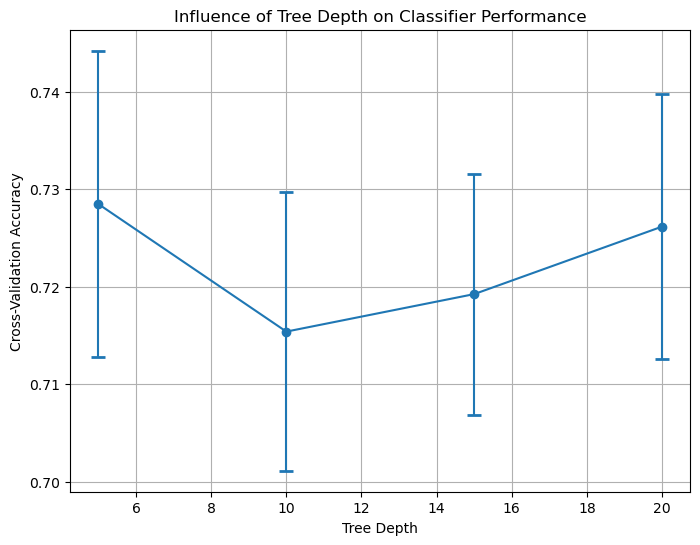

In [57]:
#DecisionTreeNode and DecisionTree from previous code
def decision_tree_cross_val_score(X, y, max_depth, min_samples, num_folds=10):
    # Shuffle the data
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    fold_size = len(y) // num_folds
    accuracies = []

    # Perform manual cross-validation
    for i in range(num_folds):
        # Split data into train and test based on the current fold
        start, end = i * fold_size, (i + 1) * fold_size
        X_test, y_test = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])

        # Train the decision tree on the training set
        tree = DecisionTreeNode(max_depth=max_depth, min_samples=min_samples)
        tree.fit(X_train, y_train)

        # Test the model on the test set and calculate accuracy
        predictions = np.array([tree.predict_one(x) for x in X_test])
        accuracy = np.mean(predictions == y_test)
        accuracies.append(accuracy)

    return np.array(accuracies)

def evaluate_tree_depths(data_file):
    # Load and shuffle the training data
    df = pd.read_csv(data_file).sample(frac=1, random_state=18)
    
    # Take a 25% sample of the shuffled data
    df_sample = df.sample(frac=0.25, random_state=25)
    X = df_sample.iloc[:, :-1].values
    y = df_sample.iloc[:, -1].values

    # Define depth limits to evaluate
    depth_limits = [5, 10, 15, 20]
    results = []

    # Evaluate each depth limit
    for depth in depth_limits:
        # Perform 10-fold cross-validation for the current depth
        scores = decision_tree_cross_val_score(X, y, max_depth=depth, min_samples=50, num_folds=10)
        
        # Store results with mean accuracy and standard error
        mean_accuracy = np.mean(scores)
        std_error = np.std(scores) / np.sqrt(len(scores))  # Standard error
        results.append((depth, mean_accuracy, std_error))

    # Plot results
    depths = [r[0] for r in results]
    accuracies = [r[1] for r in results]
    errors = [r[2] for r in results]

    plt.figure(figsize=(8, 6))
    plt.errorbar(depths, accuracies, yerr=errors, fmt='-o', capsize=5, capthick=2)
    plt.xlabel("Tree Depth")
    plt.ylabel("Cross-Validation Accuracy")
    plt.title("Influence of Tree Depth on Classifier Performance")
    plt.grid(True)
    plt.show()

evaluate_tree_depths('trainingSet.csv')

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## 4. Compare Performance of Different Models 

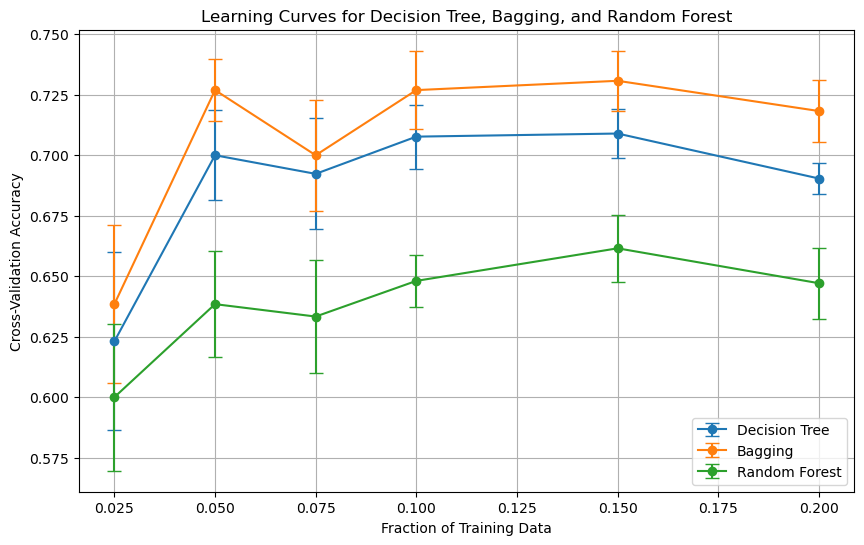

In [64]:
# Define train and predict functions for Decision Tree, Bagging, and Random Forest

# Decision Tree Training and Prediction
def train_decision_tree(X, y, max_depth=8, min_samples=50):
    tree = DecisionTreeNode(max_depth=max_depth, min_samples=min_samples)
    tree.fit(X, y)
    return tree

def predict_decision_tree(model, X):
    return np.array([model.predict_one(x) for x in X])

# Bagging Training and Prediction
def train_bagging(X, y, n_trees=30, max_depth=8, min_samples=50):
    trees = []
    n_samples = X.shape[0]
    for _ in range(n_trees):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        tree = train_decision_tree(X_sample, y_sample, max_depth, min_samples)
        trees.append(tree)
    return trees

def predict_bagging(trees, X):
    predictions = np.array([predict_decision_tree(tree, X) for tree in trees])
    return np.round(predictions.mean(axis=0)).astype(int)  # Majority vote

# Random Forest Training and Prediction
def train_random_forest(X, y, n_trees=30, max_depth=8, min_samples=50, max_features=None):
    trees = []
    n_samples, n_features = X.shape
    if max_features is None:
        max_features = int(np.sqrt(n_features))  # sqrt of total features

    for _ in range(n_trees):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        features = np.random.choice(n_features, max_features, replace=False)
        tree = DecisionTreeNode(max_depth=max_depth, min_samples=min_samples)
        tree.fit(X_sample[:, features], y_sample)
        trees.append((tree, features))
    return trees

def predict_random_forest(trees, X):
    predictions = []
    for tree, features in trees:
        pred = predict_decision_tree(tree, X[:, features])
        predictions.append(pred)
    predictions = np.array(predictions)
    return np.round(predictions.mean(axis=0)).astype(int)  # Majority vote

def cross_val_accuracy(model_train, model_predict, X, y, num_folds=10):
    fold_size = len(y) // num_folds
    accuracies = []
    
    for i in range(num_folds):
        start, end = i * fold_size, (i + 1) * fold_size
        X_test, y_test = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])
        
        model = model_train(X_train, y_train)
        predictions = model_predict(model, X_test)
        accuracy = np.mean(predictions == y_test)
        accuracies.append(accuracy)
        
    return np.mean(accuracies), np.std(accuracies) / np.sqrt(num_folds)  # mean accuracy and standard error

def evaluate_model_performance(data_file):
    # Load and shuffle the training data
    df = pd.read_csv(data_file).sample(frac=1, random_state=18)
    
    # Define fractions to evaluate
    fractions = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
    models = {
        'Decision Tree': (train_decision_tree, predict_decision_tree),
        'Bagging': (train_bagging, predict_bagging),
        'Random Forest': (train_random_forest, predict_random_forest)
    }
    results = {model: {'fractions': [], 'accuracies': [], 'errors': []} for model in models}
    
    for frac in fractions:
        df_sample = df.sample(frac=frac, random_state=32)
        X = df_sample.iloc[:, :-1].values
        y = df_sample.iloc[:, -1].values
        
        for model_name, (train_func, predict_func) in models.items():
            mean_accuracy, std_error = cross_val_accuracy(train_func, predict_func, X, y, num_folds=10)
            results[model_name]['fractions'].append(frac)
            results[model_name]['accuracies'].append(mean_accuracy)
            results[model_name]['errors'].append(std_error)

    # Plotting
    plt.figure(figsize=(10, 6))
    for model_name in models.keys():
        plt.errorbar(results[model_name]['fractions'],
                     results[model_name]['accuracies'],
                     yerr=results[model_name]['errors'],
                     label=model_name,
                     capsize=5,
                     fmt='-o')

    plt.xlabel("Fraction of Training Data")
    plt.ylabel("Cross-Validation Accuracy")
    plt.title("Learning Curves for Decision Tree, Bagging, and Random Forest")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    frac_results = results
    return frac_results
    
frac_results = evaluate_model_performance('trainingSet.csv')
 

In [65]:
accuracies_DecisionTree = frac_results['Decision Tree']['accuracies']
accuracies_Bagging = frac_results['Bagging']['accuracies']

The performance of Bagging is significantly better than that of the DecisionTree in terms of test accuracy.

In [71]:
from scipy import stats

# Assuming accuracies_DecisionTree and accuracies_Bagging are lists or arrays of accuracies
t_stat, p_value = stats.ttest_rel(accuracies_Bagging,accuracies_DecisionTree)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 6.413158982872929, p-value: 0.001367657184552114


Due to p < 0.05, reject the null hypothesis and conclude that the performance difference between Bagging and  DecisionTree is significant.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## 5.The Influence of Number of Trees on Classifier Performance

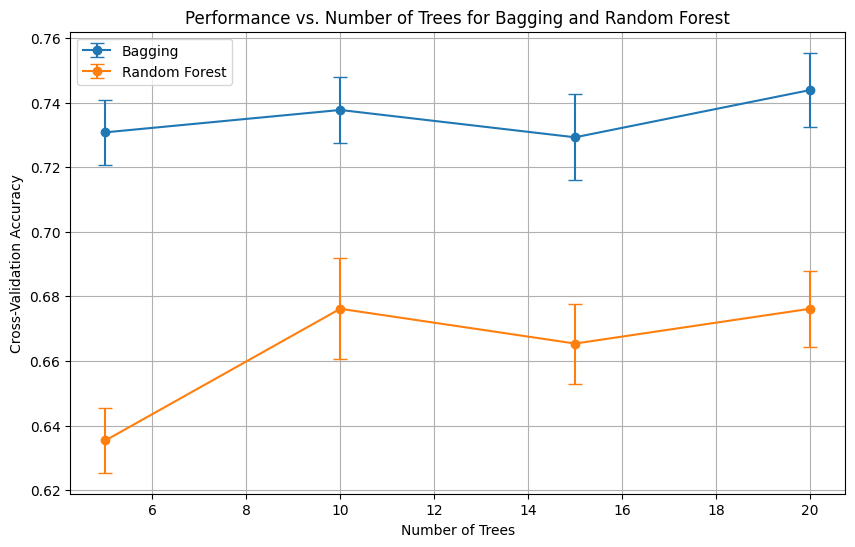

In [45]:
# Define the Bagging and Random Forest functions using predefined Decision Tree functions

def train_bagging(X, y, n_trees, max_depth=8, min_samples=50):
    trees = []
    n_samples = X.shape[0]
    for _ in range(n_trees):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        tree = DecisionTreeNode(max_depth=max_depth, min_samples=min_samples)
        tree.fit(X_sample, y_sample)
        trees.append(tree)
    return trees

def predict_bagging(trees, X):
    predictions = np.array([predict_decision_tree(tree, X) for tree in trees])
    return np.round(predictions.mean(axis=0)).astype(int)  # Majority vote

def train_random_forest(X, y, n_trees, max_depth=8, min_samples=50, max_features=None):
    trees = []
    n_samples, n_features = X.shape
    if max_features is None:
        max_features = int(np.sqrt(n_features))  # sqrt of total features

    for _ in range(n_trees):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        features = np.random.choice(n_features, max_features, replace=False)
        tree = DecisionTreeNode(max_depth=max_depth, min_samples=min_samples)
        tree.fit(X_sample[:, features], y_sample)
        trees.append((tree, features))
    return trees

def predict_random_forest(trees, X):
    predictions = []
    for tree, features in trees:
        pred = predict_decision_tree(tree, X[:, features])
        predictions.append(pred)
    predictions = np.array(predictions)
    return np.round(predictions.mean(axis=0)).astype(int)  # Majority vote

# Cross-validation function
def cross_val_accuracy(model_train, model_predict, X, y, n_trees, num_folds=10):
    fold_size = len(y) // num_folds
    accuracies = []
    
    for i in range(num_folds):
        start, end = i * fold_size, (i + 1) * fold_size
        X_test, y_test = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])
        
        model = model_train(X_train, y_train, n_trees)
        predictions = model_predict(model, X_test)
        accuracy = np.mean(predictions == y_test)
        accuracies.append(accuracy)
        
    return np.mean(accuracies), np.std(accuracies) / np.sqrt(num_folds)  # mean accuracy and standard error

def evaluate_tree_count_performance(data_file):
    # Load and shuffle data
    df = pd.read_csv(data_file).sample(frac=1, random_state=18)
    df_sample = df.sample(frac=0.25, random_state=25)
    X = df_sample.iloc[:, :-1].values
    y = df_sample.iloc[:, -1].values

    # Define different tree counts to evaluate
    tree_counts = [5, 10, 15, 20]
    models = {
        'Bagging': (train_bagging, predict_bagging),
        'Random Forest': (train_random_forest, predict_random_forest)
    }
    results = {model: {'tree_counts': [], 'accuracies': [], 'errors': []} for model in models}
    
    for n_trees in tree_counts:
        for model_name, (train_func, predict_func) in models.items():
            mean_accuracy, std_error = cross_val_accuracy(train_func, predict_func, X, y, n_trees)
            results[model_name]['tree_counts'].append(n_trees)
            results[model_name]['accuracies'].append(mean_accuracy)
            results[model_name]['errors'].append(std_error)

    # Plotting
    plt.figure(figsize=(10, 6))
    for model_name in models.keys():
        plt.errorbar(results[model_name]['tree_counts'],
                     results[model_name]['accuracies'],
                     yerr=results[model_name]['errors'],
                     label=model_name,
                     capsize=5,
                     fmt='-o')

    plt.xlabel("Number of Trees")
    plt.ylabel("Cross-Validation Accuracy")
    plt.title("Performance vs. Number of Trees for Bagging and Random Forest")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    tree_count_results=results
    return tree_count_results
    
tree_count_results = evaluate_tree_count_performance('trainingSet.csv')

In [46]:
accuracies_RandomForest0 = tree_count_results['Random Forest']['accuracies']
accuracies_Bagging0 = tree_count_results['Bagging']['accuracies']

The performance of Bagging is significantly different with that of the RandomForest in terms of test accuracy.

In [81]:
from scipy import stats

# Assuming accuracies_DecisionTree and accuracies_RandomForest are lists or arrays of accuracies
t_stat, p_value = stats.ttest_rel(accuracies_RandomForest0, accuracies_Bagging0)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: -7.196850077289943, p-value: 0.0055290715531478235


Due to p < 0.05, reject the null hypothesis and conclude that the performance difference between Bagging and RandomForest is significant.

## Bonus question 

### Boosted decision trees

In [ ]:
class DecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth=0):
        # Check stopping criteria
        if depth >= self.max_depth or len(set(y)) == 1 or len(y) < self.min_samples_split:
            return np.mean(y)  # Return mean for regression tasks
        
        # Find the best split
        n_samples, n_features = X.shape
        best_feature, best_threshold = None, None
        best_gain = -1
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx, right_idx = X[:, feature] <= threshold, X[:, feature] > threshold
                if sum(left_idx) > 0 and sum(right_idx) > 0:
                    gain = self._calculate_gain(y, y[left_idx], y[right_idx])
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = threshold
        
        # If no gain, return mean
        if best_gain == -1:
            return np.mean(y)
        
        # Split and grow children
        left_idx, right_idx = X[:, best_feature] <= best_threshold, X[:, best_feature] > best_threshold
        left_child = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right_child = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return (best_feature, best_threshold, left_child, right_child)

    def _calculate_gain(self, y, y_left, y_right):
        # Calculate information gain (for example, using Gini impurity)
        def gini(y):
            _, counts = np.unique(y, return_counts=True)
            probs = counts / counts.sum()
            return 1 - np.sum(probs ** 2)
        
        n = len(y)
        return gini(y) - (len(y_left) / n * gini(y_left) + len(y_right) / n * gini(y_right))
    
    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _predict_one(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, threshold, left_child, right_child = node
        if x[feature] <= threshold:
            return self._predict_one(x, left_child)
        else:
            return self._predict_one(x, right_child)


In [63]:
class GradientBoosting:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
    
    def fit(self, X, y):
        # Convert y to float to ensure residuals are float type
        y = y.astype(float)
        
        # Initial prediction is the mean of y
        initial_prediction = np.mean(y)
        self.initial_prediction = initial_prediction

        # Initialize residuals as floats
        residual = y - initial_prediction
        
        for _ in range(self.n_estimators):
            # Train a new tree on the residuals
            tree = DecisionTreeNode(max_depth=self.max_depth)
            tree.fit(X, residual)
            
            # Predict and update residuals
            prediction = tree.predict(X)
            residual -= self.learning_rate * prediction
            self.trees.append(tree)
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return np.round(y_pred).astype(int)


In [64]:
learning_rates = [0.05, 0.1, 0.2]
n_estimators_list = [10, 20, 30]
max_depths = [3, 5]

best_params = None
best_accuracy = 0

# Load training and test datasets
train_df = pd.read_csv('trainingSet.csv')
test_df = pd.read_csv('testSet.csv')

# Separate features and labels
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

val_split = 0.2
split_index = int((1 - val_split) * len(X_train))

# Create the training and validation sets
X_train_main, X_val = X_train[:split_index], X_train[split_index:]
y_train_main, y_val = y_train[:split_index], y_train[split_index:]

# Loop through different parameter combinations
for lr in learning_rates:
    for depth in max_depths:
        # Initialize and train the model on the main training set
        model = GradientBoosting(n_estimators=n_estimators, learning_rate=lr, max_depth=depth)
        model.fit(X_train_main, y_train_main)
        
        # Evaluate on the validation set
        predictions = model.predict(X_val)
        accuracy = np.mean(predictions == y_val)
        
        # Keep track of the best model based on validation accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

# Once tuned, evaluate on the test set (if provided separately)
print(f"Best Validation Accuracy: {best_accuracy:.2f}")


Best Validation Accuracy: 0.55


In [66]:
# Initialize best accuracy and best params
best_accuracy = 0
best_params = {}

# Hyperparameter tuning loop
for lr in learning_rates:
    for depth in max_depths:
        # Initialize and train the model on the main training set
        model = GradientBoosting(n_estimators=n_estimators, learning_rate=lr, max_depth=depth)
        model.fit(X_train_main, y_train_main)
        
        # Evaluate on the validation set
        predictions = model.predict(X_val)
        accuracy = np.mean(predictions == y_val)
        
        # Track the best accuracy and parameters
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_estimators': n_estimators, 'learning_rate': lr, 'max_depth': depth}

# Check if best_params is updated correctly
if not best_params:
    raise ValueError("No best parameters found. Check the tuning loop for issues.")

# Use the best parameters to initialize and train the final model
final_model = GradientBoosting(n_estimators=best_params['n_estimators'],
                               learning_rate=best_params['learning_rate'],
                               max_depth=best_params['max_depth'])
final_model.fit(X_train, y_train)

# Make predictions and evaluate
train_predictions = final_model.predict(X_train)
test_predictions = final_model.predict(X_test)
train_accuracy = np.mean(train_predictions == y_train)
test_accuracy = np.mean(test_predictions == y_test)

print(f"Final Training Accuracy: {train_accuracy:.2f}")
print(f"Final Testing Accuracy: {test_accuracy:.2f}")


Final Training Accuracy: 0.56
Final Testing Accuracy: 0.57


### Neural networks

In [60]:
# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Cross-entropy loss
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # To avoid log(0)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size=1, learning_rate=0.01):
        # Initialize network structure
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        
        # Input layer to first hidden layer
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        for i in range(len(layer_sizes) - 1):
            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            bias = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(weight)
            self.biases.append(bias)

    def forward(self, X):
        # Forward propagation
        activations = [X]
        inputs = []
        
        for i in range(len(self.weights) - 1):
            input = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            output = relu(input)
            inputs.append(input)
            activations.append(output)
        
        # Output layer with sigmoid
        input = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        output = sigmoid(input)
        inputs.append(input)
        activations.append(output)
        
        return inputs, activations

    def backward(self, X, y, inputs, activations):
        # Backpropagation
        m = y.shape[0]
        d_weights = [np.zeros_like(weight) for weight in self.weights]
        d_biases = [np.zeros_like(bias) for bias in self.biases]
        
        # Output layer error
        error = activations[-1] - y
        delta = error * sigmoid_derivative(inputs[-1])
        
        d_weights[-1] = np.dot(activations[-2].T, delta) / m
        d_biases[-1] = np.sum(delta, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in reversed(range(len(d_weights) - 1)):
            delta = np.dot(delta, self.weights[i + 1].T) * relu_derivative(inputs[i])
            d_weights[i] = np.dot(activations[i].T, delta) / m
            d_biases[i] = np.sum(delta, axis=0, keepdims=True) / m
        
        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * d_weights[i]
            self.biases[i] -= self.learning_rate * d_biases[i]

    def fit(self, X, y, epochs=1000):
        # Training the network
        for epoch in range(epochs):
            inputs, activations = self.forward(X)
            self.backward(X, y, inputs, activations)
            if epoch % 100 == 0:
                loss = cross_entropy_loss(y, activations[-1])
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        # Generate predictions
        _, activations = self.forward(X)
        return (activations[-1] > 0.5).astype(int)


In [61]:
# Load and prepare data
import pandas as pd

# Assuming the data is already processed and split into X_train, y_train, X_test, y_test
df_train = pd.read_csv('trainingSet.csv')
df_test = pd.read_csv('testSet.csv')

X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values.reshape(-1, 1)
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values.reshape(-1, 1)

# Define the model
input_size = X_train.shape[1]
hidden_sizes = [16, 8]  # Example hidden layers; adjust as needed
learning_rate = 0.01
epochs = 1000

# Create and train the model
nn = NeuralNetwork(input_size=input_size, hidden_sizes=hidden_sizes, learning_rate=learning_rate)
nn.fit(X_train, y_train, epochs=epochs)

# Evaluate on training and test data
train_predictions = nn.predict(X_train)
test_predictions = nn.predict(X_test)

train_accuracy = np.mean(train_predictions == y_train)
test_accuracy = np.mean(test_predictions == y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


Epoch 0/1000, Loss: 0.6931
Epoch 100/1000, Loss: 0.6922
Epoch 200/1000, Loss: 0.6914
Epoch 300/1000, Loss: 0.6907
Epoch 400/1000, Loss: 0.6901
Epoch 500/1000, Loss: 0.6895
Epoch 600/1000, Loss: 0.6890
Epoch 700/1000, Loss: 0.6886
Epoch 800/1000, Loss: 0.6882
Epoch 900/1000, Loss: 0.6879
Training Accuracy: 0.5625
Testing Accuracy: 0.5746
